# Práctica 2 - CNNs

### Natalia Martínez García, Lucía Vega Navarrete
### Grupo: AP.11.06

En esta práctica vamos a utilizar el dataset STL-10, que está diseñado para clasificación de imágenes. Vamos a ver que contiene 13,000 imágenes etiquetadas de tamaño 96×96 píxeles en color (RGB), y que estas se clasifican en 10 clases (avión, pájaro, coche, gato, ciervo, perro, caballo, mono, barco, camión). Además incluye 100,000 imágenes sin etiquetar para aprendizaje no supervisado, aunque no las vamos a utilizar. El objetivo es entrenar una red neuronal convolucional para clasificar estas imágenes.

Primero cargaremos y preprocesaremos los datos: normalizando las imágenes y convirtiendo las etiquetas a one-hot. A diferencia de la práctica anterior, no aplanaremos las imágenes, ya que queremos conservar su estructura bidimensional original para que la red pueda captar relaciones espaciales entre píxeles cercanos.

Luego, entrenaremos varios modelos aplicando distintas formas de regularización para analizar cómo afectan al rendimiento en validación y test.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import visualkeras
from keras import layers, models, regularizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt

En primer lugar importamos las librerías que vamos a utilizar a lo largo de la práctica.


In [2]:
seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Fijamos una semilla aleatoria para asegurar que los experimentos sean reproducibles y así poder compararlos mejor. Sin ella, procesos como la inicialización de pesos o el shuffle de datos producirían resultados diferentes en cada ejecución, y no podríamos determinar si las diferencias de rendimiento se deben al azar.

### 1. Carga del dataset

In [3]:
# Cargamos el dataset STL-10 ya dividido en entrenamiento y test
(train, test), info_ds = tfds.load(
    'stl10',
    split=['train', 'test'],
    as_supervised=True,  # devuelve tuplas (imagen, etiqueta)
    with_info=True # devuelve info extra del dataset (número de clases, tamaño de imagen, etc.)
)

num_clases = info_ds.features['label'].num_classes
nombres_clases = info_ds.features['label'].names
tamano_imagen = info_ds.features['image'].shape
dimension_entrada = np.prod(tamano_imagen)

print("\n" + "="*50)
print("INFORMACIÓN DEL DATASET")
print("="*50)

print(f"NOMBRE: {info_ds.name}")
print(f"\nIMÁGENES:")
print(f" - Dimensiones: {tamano_imagen}")
print(f" - Tipo: {info_ds.features['image'].numpy_dtype}")
print(f" - Longitud aplanada: {dimension_entrada}")


print(f"\nETIQUETAS:")
print(f" - Número de clases: {num_clases}")
print(f" - Clases: {', '.join(nombres_clases)}")

print(f"\nSPLITS:")
print(f" - Train: {info_ds.splits['train'].num_examples:,} imágenes")
print(f" - Test: {info_ds.splits['test'].num_examples:,} imágenes")
print(f" - Unlabelled: {info_ds.splits['unlabelled'].num_examples:,} imágenes (NO LOS USAMOS)")


INFORMACIÓN DEL DATASET
NOMBRE: stl10

IMÁGENES:
 - Dimensiones: (96, 96, 3)
 - Tipo: <class 'numpy.uint8'>
 - Longitud aplanada: 27648

ETIQUETAS:
 - Número de clases: 10
 - Clases: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck

SPLITS:
 - Train: 5,000 imágenes
 - Test: 8,000 imágenes
 - Unlabelled: 100,000 imágenes (NO LOS USAMOS)


### 2. Preprocesado

Reutilizamos código de la práctrica anterior. El único cambio realizado es que, al tener que presentar las imágenes como un mapa bidimensional, eliminamos la línea donde las aplanamos y las mantenemos en su forma original.
Como antes teníamos las imágenes aplanadas, usábamos `np.array()` para pasarlo a numpy. Ahora como tenemos las dimansiones originales, tenemos que usar `tf.stack()`

In [4]:
def preprocesado(imagen, etiqueta):
    imagen = tf.cast(imagen, tf.float32) / 255.0  # imagen a float32 y escala [0,1]
    etiqueta = tf.one_hot(etiqueta, depth = num_clases) # one-hot encoding
    return imagen, etiqueta

def preprocesado_dataset(dataset):
    # Creamos listas vacías donde almacenaremos las imágenes y etiquetas preprocesadas.
    imagenes = []
    etiquetas = []

    for img, label in dataset:
        imagen, etiqueta = preprocesado(img, label) # Aplicamos el preprocesado a cada muestra
        # Añadimos los resultafos a las listas
        imagenes.append(imagen)
        etiquetas.append(etiqueta)

    # Convertimos a arrays de numpy (manteniendo las 3 dimensiones)
    return tf.stack(imagenes).numpy(), tf.stack(etiquetas).numpy()

# Aplicamos la funcion a los conjuntos de entrenamiento y test
train_inputs, train_targets = preprocesado_dataset(train)
test_inputs, test_targets = preprocesado_dataset(test)


print("Shape de train_inputs:", train_inputs.shape)
print("Shape de train_targets:", train_targets.shape)

Shape de train_inputs: (5000, 96, 96, 3)
Shape de train_targets: (5000, 10)


- Las imágenes vienen en formato uint8 (enteros sin signo), con valores de píxeles  entre 0 y 255, por lo que **escalamos** los píxeles al rango [0, 1] dividiendo por 255 para que la red converja más rápido y de forma más estable.

- A diferencia de la P1, no se aplanan las imágenes. En este caso se mantienen con su estructura tridimensional original (96, 96, 3) para conservar la información espacial entre píxeles y poder aprovechar las operaciones de convolución que realiza la CNN.

- Usamos **one-hot encoding** cuando tenemos variables categóricas que no tiene sentido ordenar (no hay una categoría “mayor” o “menor” que la otra), como es nuestro caso con las 10 clases del dataset (avión, pájaro, coche, gato, etc.). Con esto convertimos una etiqueta categórica en un vector donde solo la posición correspondiente a esa categoría tiene un 1 y el resto son 0s (por ejemplo, la clase 0 se convierte en [1,0,0,0,0,0,0,0,0,0]). Si dejáramos las etiquetas como números del 0 al 9, podría interpretarse erróneamente que existe una relación de orden entre ellas.

####  División del dataset

In [5]:
# Permutación aleatoria de índices para mezclar los datos
# Para que la división train/validation sea aleatoria
indices_permutation = np.random.permutation(len(train_inputs))
shuffled_inputs = train_inputs[indices_permutation]
shuffled_targets = train_targets[indices_permutation]

# Calculamos cuántas muestras coger para validación (20% del de entrenamiento)
num_validation_samples = int(0.2 * len(train_inputs))

# Separamos el primer 20% para validación
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
# El resto se mantiene para entrenamiento
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]

Dividimos el conjunto de entrenamiento original en dos partes: **entrenamiento** (80%) y **validación** (20%), lo que queda en 4000 imágenes para entrenamiento y 1000 para validación. El conjunto de entrenamiento se usa para que el modelo aprenda ajustando sus pesos, mientras que el de validación sirve para evaluar su rendimiento durante el entrenamiento sin que el modelo vea esos datos en el proceso de aprendizaje. Lo vamos a usar para **detectar sobreajuste** (si la accuracy en entrenamiento sube pero en validación baja, el modelo está memorizando en lugar de generalizar).

Para la división del dataset, se mezclan las muestras del conjunto de entrenamiento, de manera que la separación entre entrenamiento y validación sea aleatoria. La división que hemos escogido permite evaluar correctamente el modelo sin reducir demasiado la cantidad de datos disponibles para entrenar.

El conjunto de test, por su parte, permanece completamente separado y solo se usa al final para evaluar el rendimiento real del modelo en datos nunca vistos.

### 3. Creación y entrenamiento de modelos convolucionales personalizados para el problema de clasificación

Reutilizamos esta función que desarrollamos en la P1 que incluye todo el proceso de entrenamiento y evaluación para evitar repetir código cada vez que entrenemos un modelo diferente.

In [6]:
def entrenar(modelo, train, val, test, epochs=15):

    # Desempaquetamos los conjuntos de datos
    train_x, train_y = train
    val_x, val_y = val
    test_x, test_y = test

    # Entrenamos el modelo
    history = modelo.fit(
        train_x, train_y,
        validation_data=(val_x, val_y),
        epochs=epochs,
        batch_size=128,
    )

    # Evaluamos el modelo en test y mostramos resultados
    loss, acc, prec, rec, f1 = modelo.evaluate(test_x, test_y, verbose=0)

    print("\nResultados en TEST:")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")

    return history, loss, acc, prec, rec, f1

Utilizamos la división de training y validación para entrenar el modelo con los siguientes parámetros:

- **15 epochs** por defecto (cada epoch es una pasada completa por todos los datos de entrenamiento). Sin embargo, este parámetro lo ajustaremos después si es necesario en función del modelo. Con un número de epochs muy bajo este no aprende bien y si es muy alto puede haber mucho sobreajuste.

- **Batch_size de 128** para conseguir un punto medio entre ejecuciones rápidas y mejor estabilidad. Tras probar también con  32, 64 y 256, este fue el que nos dio mejores resultados.

- **Early Stopping** (opcional). Detiene automáticamente el entrenamiento cuando el modelo deja de mejorar. También podemos pasar distintos parámetros para configurarlo.
    - Por defecto monitorizamos el loss de validación con una paciencia de 3 epochs. Ambas cosas se pueden cambiar.
    - Lo configuramos para que restaure el modelo con los mejores pesos encontrados durante el entrenamiento, no el último.



Después del entrenamiento, evaluamos el rendimiento del modelo con el conjunto de test, usando las siguientes métricas:

- **Loss**: mide cómo de equivocado está el modelo (compara lo que predijo con lo que debería haber dicho).
- **Accuracy**: nos da el porcentaje total de aciertos. En nuestro caso las clases están balanceadas, por lo que es bastante fiable. Aun así, lo vamos a respaldar con las siguientes métricas.
- **Precision**: mide cuántas de las predicciones positivas del modelo son realmente correctas, evitando falsos positivos (de todas las veces que el modelo dijo "esto es un gato", ¿cuántas veces acertó?).
- **Recall**: evalúa falsos negativos (cuando no detecta algo que sí es)(de todos los gatos reales en el dataset, ¿cuántos detectó correctamente?).
- **F1-score**: combina precision y recall en una sola métrica y siempre es balanceado.

In [7]:
def plot(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(accuracy) + 1)

    # Crear figura con 2 subplots lado a lado
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Gráfica de accuracy
    ax1.plot(epochs, accuracy, "b-o", label="Training accuracy")
    ax1.plot(epochs, val_accuracy, "r--o", label="Validation accuracy")
    ax1.set_title("Training and validation accuracy")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Gráfica de loss
    ax2.plot(epochs, loss, "b-o", label="Training loss")
    ax2.plot(epochs, val_loss, "r--o", label="Validation loss")
    ax2.set_title("Training and validation loss")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Utilizamos la función **plot** para enseñar gráficamente como van cambiando trainig y test y detectar más fácilmente el overfitting. Está tomada del **Laboratorio 5 (Optimización)**, siendo la única diferencia que hemos hecho que las gráficas salgan una al lado de la otra y no una encima de la otra para que ocupen menos espacio.


#### 3.1. Modelo 1 - CNN base


In [8]:
def cnn_base(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    cnn_base = models.Model(inputs, outputs, name="cnn_base")
    return cnn_base

cnn_base = cnn_base(tamano_imagen,num_clases)

cnn_base.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
loss='categorical_crossentropy',
metrics=[
    'accuracy',
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.F1Score(name='f1_score', average='macro')
])

cnn_base.summary()


Model: "cnn_base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 12, 12, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 6, 6, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        92,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,666 (4.08 MB)

 Trainable params: 1,070,666 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

Empezamos con una red **convolucional base (CNN)**, diseñada para trabajar directamente con imágenes sin necesidad de aplanarlas desde el inicio. Su objetivo es que las capas iniciales detecten automáticamente patrones espaciales como bordes, texturas y formas, para que las capas posteriores puedan combinarlos en representaciones más complejas.

La arquitectura final que hemos utilizado es la siguiente:

- **Capa de entrada**: recibe imágenes de tamaño (96, 96, 3), es decir, de 96×96 píxeles y tres canales (RGB).

- **Bloques convolucionales**: se aplican varias capas *Conv2D* con filtros de tamaños crecientes (32, 64, 128 y dos de 256). Cada una utiliza un *kernel* de 3×3, activación *ReLU* y *padding="same"*, lo que permite mantener las dimensiones espaciales tras cada convolución.
  - Las primeras capas capturan rasgos simples (bordes, colores o texturas), mientras que las más profundas aprenden características más abstractas (formas o estructuras completas de los objetos).

- **Capas de *Pooling***: después de las convoluciones se alternan capas de *MaxPooling2D* y *AveragePooling2D* con tamaño 2×2, que reducen poco a poco la resolución de las imágenes y el número de parámetros. *MaxPooling* conserva las características más relevantes, mientras que *AveragePooling* suaviza la información para evitar excesivo sobreajuste.

- **Capa de aplanamiento (*Flatten*)**: transforma los mapas de características obtenidos por las capas convolucionales en un vector unidimensional para poder conectarlo con la capa de salida.

- **Capa de salida**: totalmente conectada (*Dense*) con tantas neuronas como clases (en este caso 10) y activación *softmax*, que genera una distribución de probabilidad entre las clases posibles.

Usamos el optimizador **Adam** con un learning rate inicial de 0.0003 para ajustar los pesos automáticamente durante el entrenamiento. Converge rápido y se utiliza mucho actualmente. Como función de **loss** para penalizar predicciones incorrectas, utilizamos *Categorical Crossentropy* al tratarse de una clasificación multiclase que además hemos puesto en forma one-hot.

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 274ms/step - accuracy: 0.1337 - f1_score: 0.0948 - loss: 2.2483 - precision: 0.2128 - recall: 0.0015 - val_accuracy: 0.2500 - val_f1_score: 0.1962 - val_loss: 2.0916 - val_precision: 0.4353 - val_recall: 0.0740
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.3277 - f1_score: 0.2946 - loss: 1.8468 - precision: 0.6523 - recall: 0.0843 - val_accuracy: 0.3150 - val_f1_score: 0.2846 - val_loss: 1.8386 - val_precision: 0.5087 - val_recall: 0.1470
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.4079 - f1_score: 0.3823 - loss: 1.6252 - precision: 0.6732 - recall: 0.1604 - val_accuracy: 0.3820 - val_f1_score: 0.3651 - val_loss: 1.6569 - val_precision: 0.5631 - val_recall: 0.1830
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.4539 - f1_score: 0.4364 - loss: 1.4940 - precision: 0.6962 - recall: 0.2270 - val_accuracy: 0.4190 - val_f1_score: 0.4025 - val_loss: 1.5890 - val_precision: 0.5805 - val_recall: 0

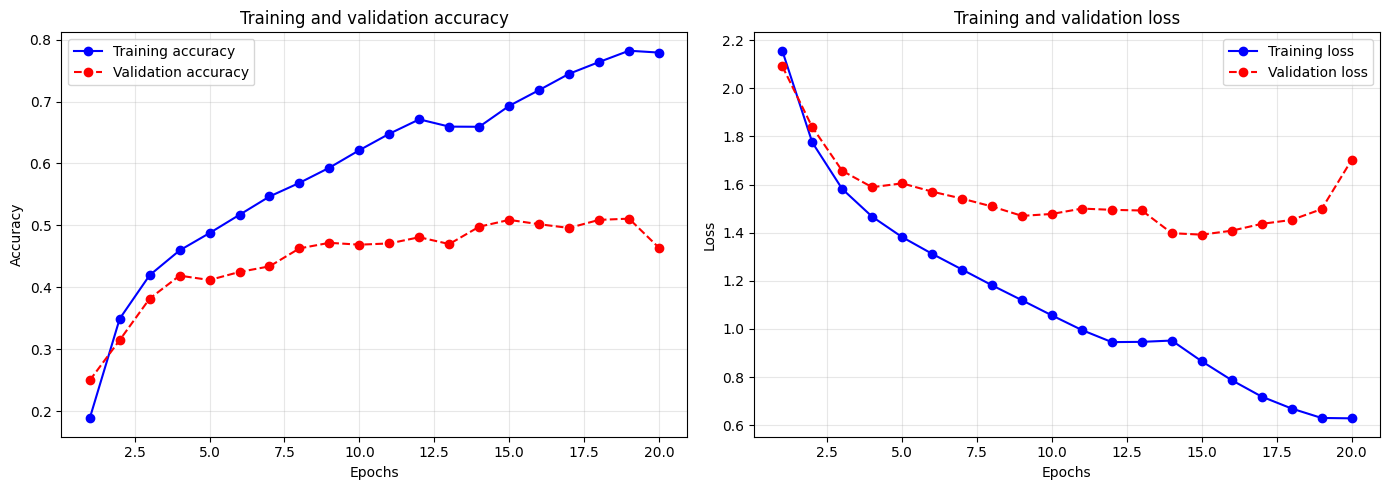

/usr/local/lib/python3.12/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


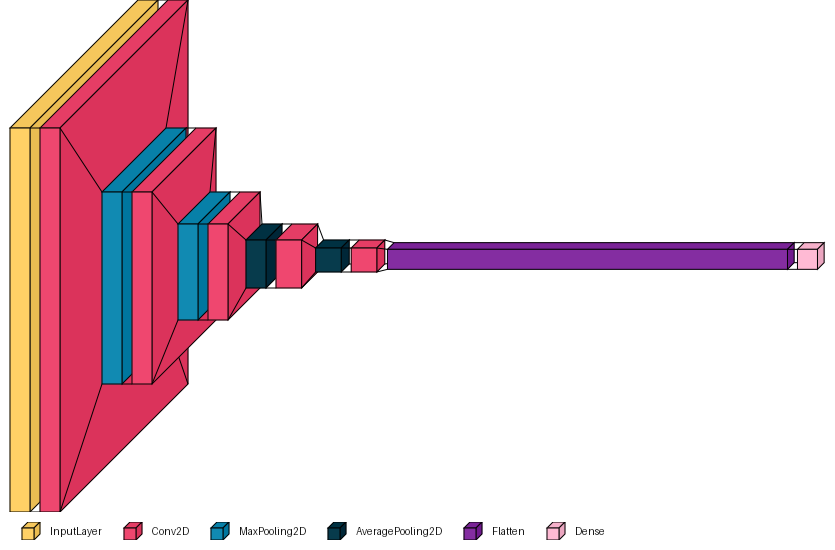

In [9]:
hist_base, loss_base, acc_base, prec_base, rec_base, f1_base= entrenar(
    cnn_base,
    (training_inputs, training_targets),(val_inputs, val_targets),(test_inputs, test_targets), epochs = 20
)

plot(hist_base)
visualkeras.layered_view(cnn_base, legend=True)

Con estos resultados observamos que el modelo **aprende correctamente durante el entrenamiento**, pero empieza a mostrar síntomas de **sobreajuste**.
El *accuracy* de entrenamiento aumenta de forma constante desde un 13% hasta llegar al **~80%**, mientras que la de validación se queda estancada alrededor del **45–50%**, sin mostrar mejoras significativas a partir de la mitad del entrenamiento.
En la gráfica vemos que la pérdida de entrenamiento baja de forma continua, pero la pérdida de validación deja de mejorar y, hacia las últimas épocas, incluso empeora ligeramente.
Esto indica que la red está capturando muy bien los patrones del conjunto de entrenamiento, pero **no logra generalizar** con la misma eficacia al conjunto de validación.

Los resultados finales en test confirman esta tendencia:

* El **accuracy de 49.35%** refleja que el modelo acierta aproximadamente la mitad de las imágenes, lo que evidencia que ha aprendido patrones, aunque aún presenta margen de mejora.
* El **precision de 58.55%** indica que cuando el modelo decide una clase, suele acertar en más de la mitad de los casos, mostrando predicciones relativamente consistentes.
* El **recall de 41.45%** revela que el modelo solo identifica correctamente unos 4 de cada 10 ejemplos reales, dejando escapar bastantes casos, lo que sugiere una detección incompleta.
* La combinación entre precision y recall se refleja en un **F1-score de 0.48**, consistente con ese comportamiento intermedio.
* El **Loss de 1.60** está en línea con lo observado en validación, lo que indica una generalización moderada, acorde al grado de sobreajuste detectado.

#### Aplicación de técnicas de regularización

A partir del modelo base, hemos probado algunas técnicas de regularización para reducir el overfitting y mejorar la capacidad de generalización de la red:

lo hacemos luego cuando esté todo lmao


#### 3.2 Modelo 2 - Data augmentation

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [11]:
def data_aug(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    data_aug = models.Model(inputs, outputs, name="data_augmentation")
    return data_aug

data_aug = data_aug(tamano_imagen,num_clases)

data_aug.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
loss='categorical_crossentropy',
metrics=[
    'accuracy',
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.F1Score(name='f1_score', average='macro')
])

data_aug.summary()


Model: "data_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 12, 12, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 6, 6, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        92,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,666 (4.08 MB)

 Trainable params: 1,070,666 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

Aquí añadimos **Data Augmentation** justo **desués de la entrada** para que cada imagen de entrenamiento se transforme **de forma aleatoria en cada epoch**, permitiendo que el modelo vea versiones diferentes de las mismas imágenes y así reduzca el sobreajuste sin modificar el conjunto de validación ni el de test.

**Bloque de aumento de datos usado:**

- **RandomFlip("horizontal"):** Invierte la imagen izquierda-derecha aleatoriamente. En STL-10 (avión, coche, perro, etc.) un giro horizontal mantiene el significado visual y añade vistas simétricas útiles. *Evitamos el vertical flip* porque generaría escenas poco realistas (barcos/aviones “boca abajo”).
- **RandomRotation(0.1):** Introduce pequeñas rotaciones para hacer el modelo robusto a leves desalineaciones propias de la captura. Un rango corto evita deformaciones fuertes que cambien la clase.
- **RandomZoom(0.2):** Simula cambios de escala/distancia a cámara. Ayuda a que los filtros aprendan patrones que se reconocen tanto de cerca como de lejos.

**Por qué estos valores:**

- Son transformaciones **geométricas suaves** que **conservan la clase** y respetan la composición típica del dataset.
- El rango es **moderado** (10–20%) para no introducir cambios ni recortes excesivos en imágenes de **96×96 píxeles**, donde el detalle es limitado.
  - Evitamos transformaciones agresivas (rotaciones grandes, recortes fuertes, vertical flip) para no degradar la semántica.

**Por qué en esa posición del modelo:** Se aplica **antes de las convoluciones**, sobre los **tensores de entrada**, para que todas las capas vean datos variados desde el inicio.

Lo que buscamos con esto es hacer al modelo **invariante** a pequeñas rotaciones, espejos y cambios de escala; y **reducir la memorización** de detalles específicos del conjunto de entrenamiento.

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.1315 - f1_score: 0.0839 - loss: 2.2676 - precision: 0.1835 - recall: 9.5488e-04 - val_accuracy: 0.2390 - val_f1_score: 0.1898 - val_loss: 2.1009 - val_precision: 0.5180 - val_recall: 0.0720
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.2998 - f1_score: 0.2670 - loss: 1.9160 - precision: 0.6525 - recall: 0.0558 - val_accuracy: 0.2690 - val_f1_score: 0.2303 - val_loss: 1.9314 - val_precision: 0.4368 - val_recall: 0.1140
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.3703 - f1_score: 0.3345 - loss: 1.7521 - precision: 0.6412 - recall: 0.1019 - val_accuracy: 0.3130 - val_f1_score: 0.2825 - val_loss: 1.9953 - val_precision: 0.4263 - val_recall: 0.1590
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.3961 - f1_score: 0.3688 - loss: 1.6682 - precision: 0.6574 - recall: 0.1495 - val_accuracy: 0.3690 - val_f1_score: 0.3522 - val_loss: 1.8036 - val_precision: 0.4947 - val_recall

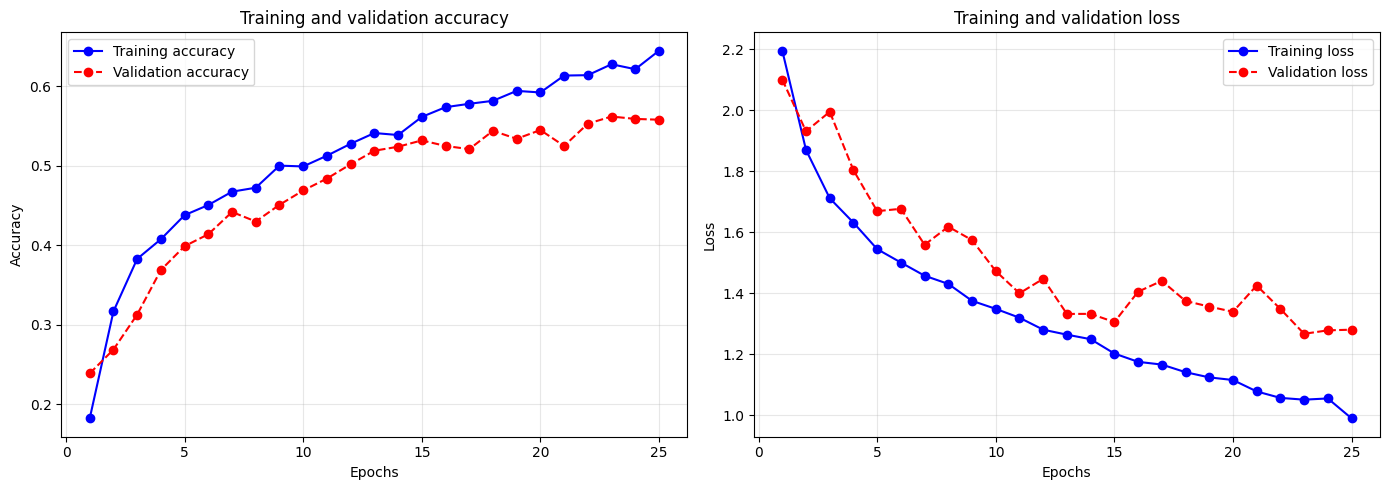

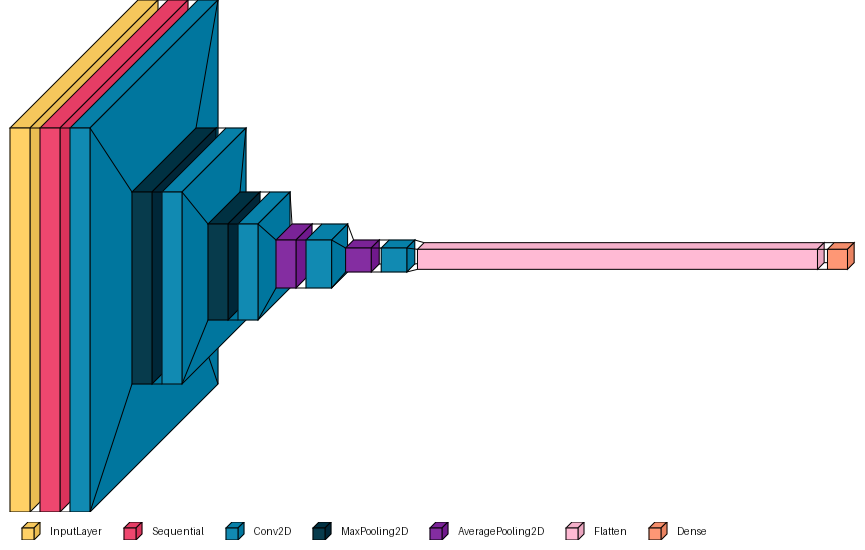

In [12]:
hist_data_aug, loss_data_aug, acc_data_aug, prec_data_aug, rec_data_aug, f1_data_aug= entrenar(
    data_aug,
    (training_inputs, training_targets),(val_inputs, val_targets),(test_inputs, test_targets), epochs = 25
)

plot(hist_data_aug)
visualkeras.layered_view(data_aug, legend=True)

Con estos resultados, vemos que el **Data Augmentation ha mejorado la generalización del modelo** respecto al CNN base.
Durante el entrenamiento, el *accuracy* en los datos de entrenamiento asciende de forma progresiva desde un 13% hasta situarse en torno al **65%**, mientras que la *validation accuracy* alcanza aproximadamente un **56%**, manteniéndose relativamente cercana a la curva de entrenamiento en la mayor parte del entrenamiento.
En la gráfica de *loss* se aprecia que tanto el *training loss* como el *validation loss* descienden de manera estable, convergiendo alrededor de **1.0–1.3** sin mostrar divergencias significativas. Esto contrasta con el modelo base, donde sí había una separación clara entre ambas curvas.

Esto indica que el modelo no solo está aprendiendo mejor, sino que además **ha reducido el sobreajuste** gracias al aumento de datos. Las transformaciones aleatorias han permitido que el modelo vea una mayor diversidad de ejemplos, evitando que memorice patrones concretos del conjunto de entrenamiento.

Los resultados finales en **test** lo confirman:

* El **accuracy de 58.90%** supone una clara **mejora respecto al modelo base**, donde el rendimiento era inferior. Esto indica que el modelo generaliza mejor ante datos nuevos.
* La **precision de 69.10%** muestra que cuando el modelo realiza una predicción, acierta con una fiabilidad notablemente mayor, evidenciando decisiones más seguras.
* El **recall de 47.49%** significa que el modelo identifica correctamente casi la mitad de los ejemplos reales de cada clase, mejorando también frente al modelo sin Data Augmentation.
* El **F1-score de 0.58** refleja un equilibrio adecuado entre precision y recall, coherente con la mejora global del modelo.
* El **loss de 1.20** es inferior al del modelo base, señal de un aprendizaje más sólido y estable.

Con esto, podemos decir que el **modelo con Data Augmentation ha reducido el sobreajuste y ha mejorado la capacidad de generalización** del modelo base, logrando un rendimiento más consistente tanto en validación como en test.

#### 3.3 Modelo 3 - Dropout

In [13]:
def dropout(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    dropout = models.Model(inputs, outputs, name="dropout")
    return dropout

dropout = dropout(tamano_imagen, num_clases)

dropout.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.F1Score(name='f1_score', average='macro')
    ]
)

dropout.summary()


Model: "dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 12, 12, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 6, 6, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        92,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,666 (4.08 MB)

 Trainable params: 1,070,666 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

Hemos añadido **Dropout** en la última parte del modelo, justo después de la capa **Flatten**, para reducir el **sobreajuste** y mejorar la capacidad de generalización sin modificar la estructura convolucional del modelo base.
La arquitectura se mantiene igual en todas las capas convolucionales y de pooling, pero antes de la capa densa final introducimos una desactivación aleatoria del **50% de las neuronas**.

Aplicar *Dropout* en esta posición tiene una función muy concreta: tras el *Flatten*, la red concentra toda la información extraída por las capas convolucionales en un vector de alta dimensión, y es precisamente aquí donde el modelo tiende más a memorizar patrones específicos del conjunto de entrenamiento.
Al desactivar aleatoriamente la mitad de estas neuronas, obligamos al modelo a **no depender de combinaciones concretas de activaciones** y a distribuir mejor la representación aprendida.

**Por qué este valor:** elegimos un *Dropout* de 0.5 porque esta capa es la más propensa al sobreajuste. Tasas más bajas no tenían suficiente impacto y tasas más altas reducían demasiado la capacidad del modelo. Con un 50%, conseguimos un equilibrio entre regularización y preservación de la información.

**Por qué en esa posición:** colocarlo justo después de *Flatten* evita interferir con la extracción de características que realizan las convoluciones y los *poolings*. Así, todas las capas anteriores pueden aprender patrones visuales de forma estable, y el *Dropout* actúa únicamente en el momento crítico donde la red combina toda esa información para tomar la decisión final.

Con este cambio buscamos **reducir la brecha entre entrenamiento y validación**, estabilizar el comportamiento de *val_loss* y hacer que el modelo sea más robusto al enfrentarse a ejemplos que no ha visto antes, mejorando así su capacidad de generalización.


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.1337 - f1_score: 0.0960 - loss: 2.2665 - precision: 0.2040 - recall: 0.0011 - val_accuracy: 0.2160 - val_f1_score: 0.1612 - val_loss: 2.1413 - val_precision: 0.5000 - val_recall: 0.0710
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.2827 - f1_score: 0.2594 - loss: 1.9371 - precision: 0.6127 - recall: 0.0538 - val_accuracy: 0.3120 - val_f1_score: 0.2870 - val_loss: 1.8499 - val_precision: 0.5467 - val_recall: 0.1230
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.3701 - f1_score: 0.3462 - loss: 1.6956 - precision: 0.6650 - recall: 0.1365 - val_accuracy: 0.3690 - val_f1_score: 0.3508 - val_loss: 1.6789 - val_precision: 0.6175 - val_recall: 0.1550
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.4246 - f1_score: 0.4075 - loss: 1.5727 - precision: 0.6843 - recall: 0.1835 - val_accuracy: 0.3840 - val_f1_score: 0.3655 - val_loss: 1.6671 - val_precision: 0.5785 - val_recall: 0

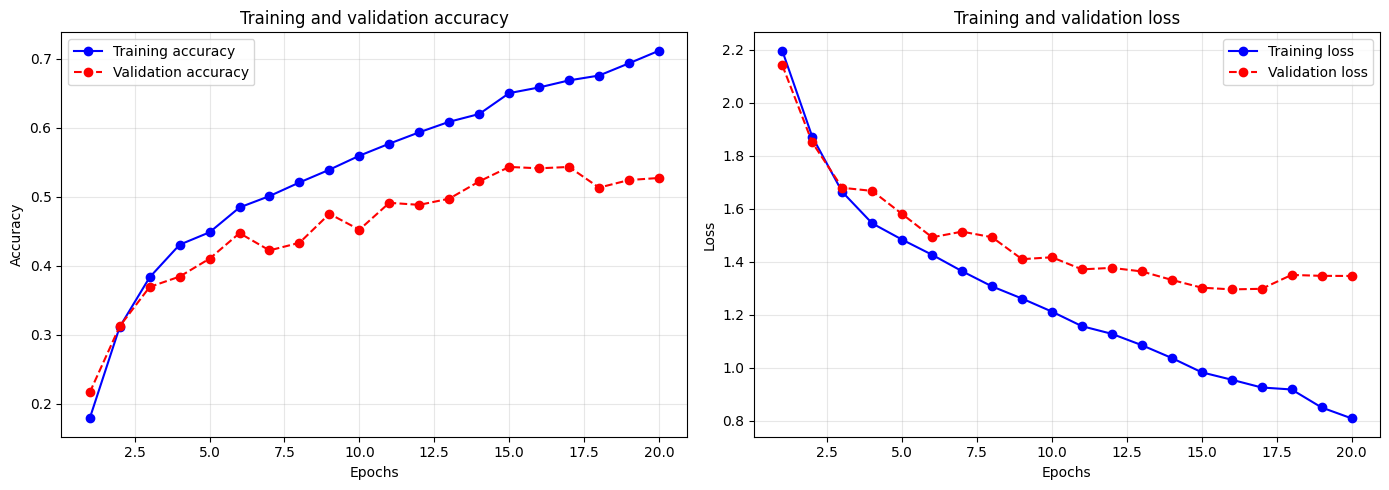

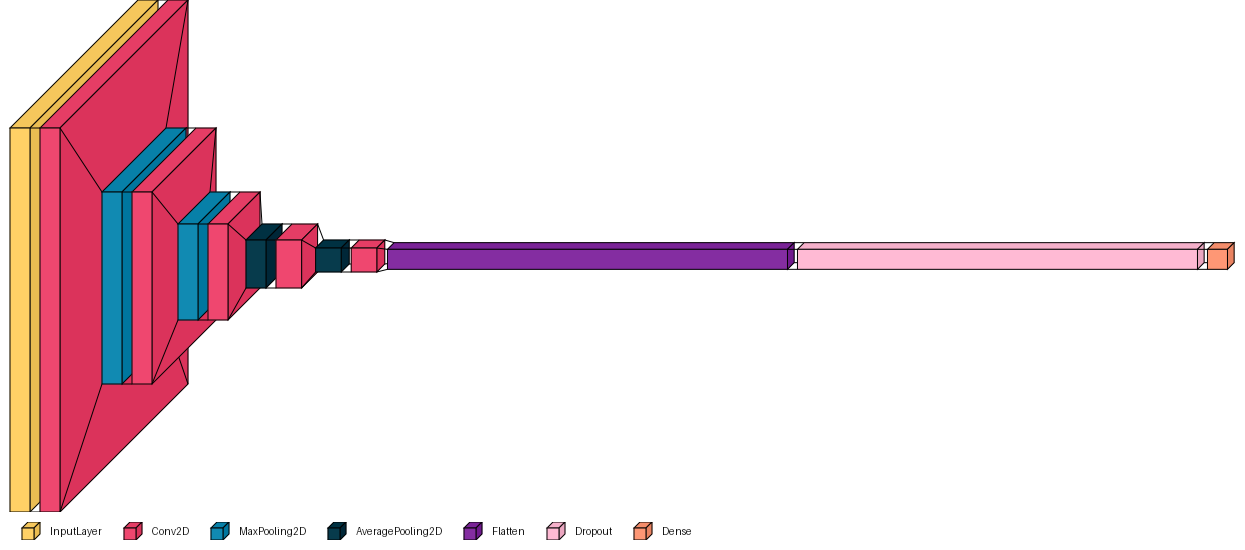

In [14]:
hist_dropout, loss_dropout, acc_dropout, prec_dropout, rec_dropout, f1_dropout= entrenar(
    dropout,
    (training_inputs, training_targets),(val_inputs, val_targets),(test_inputs, test_targets), epochs = 20
)

plot(hist_dropout)
visualkeras.layered_view(dropout, legend=True)

Con estos resultados, observamos que el **Dropout ha mejorado la estabilidad del entrenamiento y ha reducido un poco el sobreajuste**.
En las gráficas se aprecia que el *accuracy* de entrenamiento aumenta progresivamente desde un 13% hasta alrededor del **71%**, mientras que la *validation accuracy* se mantiene alrededor del **52–54%**, sin grandes oscilaciones. Esto indica que el modelo aprende de manera controlada y no memoriza tan rápido como el modelo base.

El *loss* de entrenamiento desciende de forma continua hasta valores cercanos a **0.82**, mientras que el *loss* de validación se mantiene alrededor de **1.30–1.35**, sin incrementos bruscos hacia el final del entrenamiento. Esta evolución suave sugiere que la regularización mediante *Dropout* está funcionando y que el modelo generaliza mejor sin degradación en las últimas épocas.

Los resultados en **test** refuerzan esta idea:

* **Accuracy: 55.61%**, ligeramente superior al del modelo base, mostrando una mejora en la capacidad de generalización.
* **Precision: 66.82%**, indicando que, cuando el modelo predice una clase, acierta en aproximadamente 2 de cada 3 casos.
* **Recall: 44.64%**, más bajo que la precisión, lo que significa que todavía se le escapan algunos ejemplos, aunque se mantiene dentro de un rango coherente con la validación.
* **F1-score: 0.5537**, que refleja un equilibrio razonable entre precisión y cobertura, consistente con las mejoras en estabilidad.
* **Loss: 1.28**, más bajo que el del modelo base, lo que confirma un aprendizaje más eficaz.

En conjunto, el modelo con Dropout consigue **curvas de validación más estables**, un **descenso más controlado del loss** y una **mejor generalización en test**. Aunque todavía se aprecia cierta diferencia entre entrenamiento y validación, esta es menor y mucho más manejable. El uso del *Dropout* justo antes de la capa densa final ha permitido regularizar la parte más propensa al sobreajuste sin comprometer la capacidad del modelo para aprender patrones visuales complejos.


#### 3.4 Modelo 4 - Híbrido

In [15]:
# DATA AUG + DROPOUT
def hibrido(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    modelo = models.Model(inputs, outputs, name="modelo_hibrido")
    return modelo

hibrido = hibrido(tamano_imagen,num_clases)

hibrido.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
loss='categorical_crossentropy',
metrics=[
    'accuracy',
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.F1Score(name='f1_score', average='macro')
])

hibrido.summary()


Model: "modelo_hibrido"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 12, 12, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_7             │ (None, 6, 6, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        92,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,666 (4.08 MB)

 Trainable params: 1,070,666 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

En este modelo hemos combinado **Data Augmentation** y **Dropout** para reforzar la capacidad de generalización sin cambiar la estructura convolucional principal del CNN.
La secuencia de capas convolucionales y de *pooling* se mantiene, pero ahora introducimos primero un bloque de **data_augmentation** directamente sobre la imagen de entrada y, al final, añadimos un **Dropout del 40%** tras la capa **Flatten**, justo antes de la capa densa de clasificación.

* El bloque de *data_augmentation*, como explicado anteriormente, genera variaciones aleatorias a partir de cada imagen de entrada, de forma que la red ve durante el entrenamiento muchas versiones distintas de los mismos datos. Esto hace que las capas convolucionales aprendan patrones más robustos y menos sensibles a pequeñas variaciones en la imagen.

* Después de las convoluciones y los *poolings*, la capa **Flatten** condensa todas las características extraídas en un vector de alta dimensión. Es en este punto donde aplicamos **Dropout(0.4)** : al desactivar aleatoriamente un 40% de las neuronas, obligamos al modelo a **no depender de combinaciones concretas de activaciones** y a repartir mejor la información entre distintas unidades.

**Por qué este valor:** elegimos un *Dropout* de **0.4** porque el *data augmentation* ya regulariza bastante. Con un 40% añadimos control al sobreajuste sin llegar a borrar demasiada información útil en esta última parte del modelo.

**Por qué en esas posiciones:** situar el *data_augmentation* al principio tiene sentido porque modifica directamente las imágenes de entrada, generando diversidad antes de cualquier operación convolucional. Colocar el *Dropout* justo después de *Flatten* evita interferir con la estructura espacial que construyen las convoluciones y los *poolings*, y actúa justo en el momento crítico en el que el modelo combina todas las características para tomar la decisión final.

Con este diseño híbrido buscamos **reducir aún más la brecha entre entrenamiento y validación**, estabilizar el comportamiento de *val_loss* y obtener un modelo más robusto frente a variaciones en los datos reales, aprovechando simultáneamente la diversidad que aporta el *Data Augmentation* y la regularización del *Dropout*.

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.1469 - f1_score: 0.0997 - loss: 2.2565 - precision: 0.1981 - recall: 0.0011 - val_accuracy: 0.2440 - val_f1_score: 0.1845 - val_loss: 1.9749 - val_precision: 0.5185 - val_recall: 0.0280
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.2897 - f1_score: 0.2499 - loss: 1.9402 - precision: 0.5618 - recall: 0.0353 - val_accuracy: 0.2730 - val_f1_score: 0.2412 - val_loss: 1.9849 - val_precision: 0.4405 - val_recall: 0.1110
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.3565 - f1_score: 0.3248 - loss: 1.7873 - precision: 0.6601 - recall: 0.0996 - val_accuracy: 0.2990 - val_f1_score: 0.2692 - val_loss: 2.1031 - val_precision: 0.4103 - val_recall: 0.1600
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.3894 - f1_score: 0.3666 - loss: 1.7069 - precision: 0.6530 - recall: 0.1535 - val_accuracy: 0.3400 - val_f1_score: 0.3101 - val_loss: 1.8606 - val_precision: 0.4944 - val_recall: 0.1

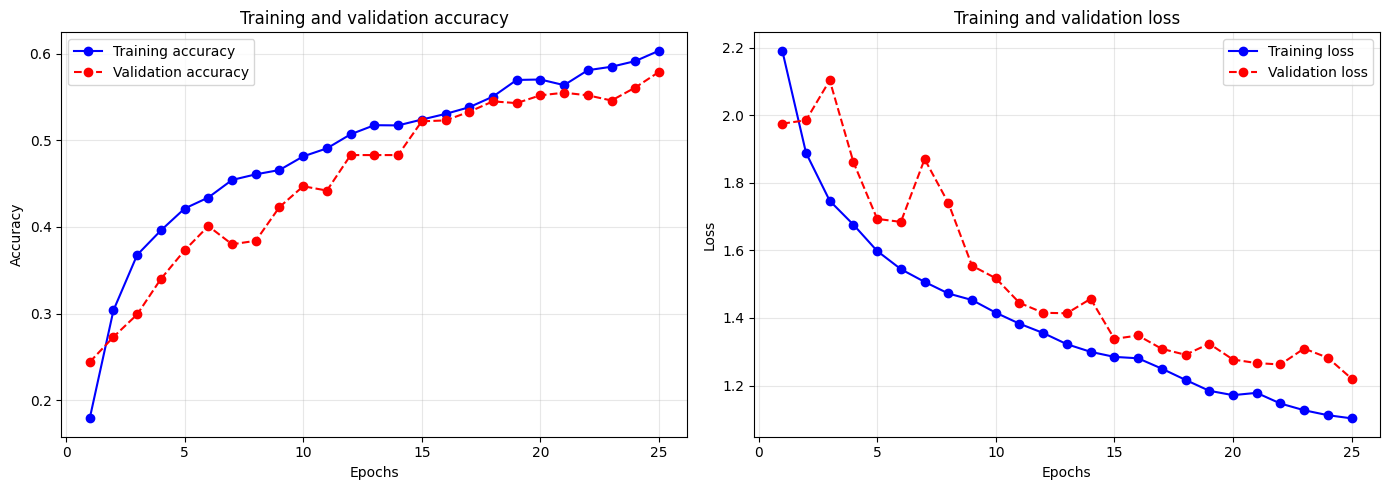

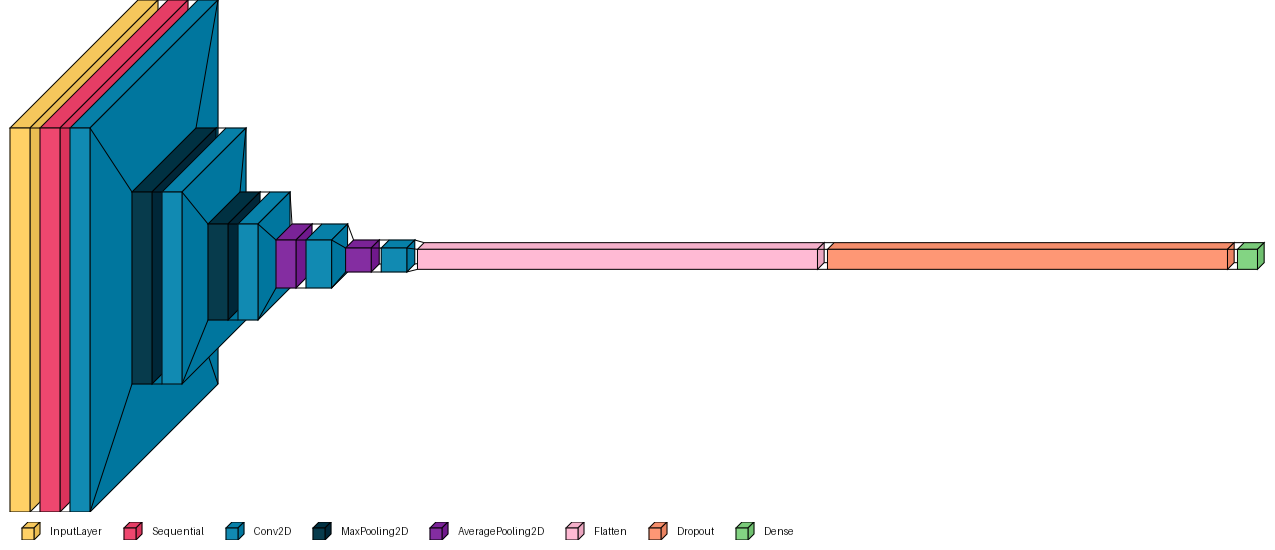

In [16]:
hist_hibrido, loss_hibrido, acc_hibrido, prec_hibrido, rec_hibrido, f1_hibrido= entrenar(
    hibrido,
    (training_inputs, training_targets),(val_inputs, val_targets),(test_inputs, test_targets), epochs = 25
)

plot(hist_hibrido)
visualkeras.layered_view(hibrido, legend=True)

Con estos resultados, observamos que la combinación de **Data Augmentation y Dropout** ha conseguido un entrenamiento más estable y una reducción notable del sobreajuste.
En las gráficas se aprecia que el *accuracy* de entrenamiento crece de forma progresiva desde un 14% hasta situarse alrededor del **59–60%**, mientras que la *validation accuracy* sigue un patrón muy similar, alcanzando aproximadamente un **57–58%** sin grandes oscilaciones. Esta cercanía entre ambas curvas indica que el modelo está aprendiendo de manera equilibrada y sin tendencia fuerte a memorizar los datos.

El *loss* de entrenamiento desciende de forma constante hasta valores cercanos a **1.12**, mientras que el *loss* de validación se mantiene entre **1.25 y 1.30**, mostrando fluctuaciones suaves pero sin degradación final. Esta evolución sugiere que el efecto combinado del aumento de datos y el *Dropout* del 40% está funcionando correctamente, ayudando al modelo a generalizar sin perder estabilidad en las últimas épocas.

Los resultados en **test** refuerzan esta idea:

* **Accuracy: 59.44%**, mostrando una mejora sostenida que confirma la mayor capacidad de generalización.
* **Precision: 71.55%**, lo que indica que cuando el modelo decide una clase lo hace con un nivel alto de acierto.
* **Recall: 48.09%**, más bajo que la precisión, señal de que el modelo aún puede captar más ejemplos reales, aunque el valor es coherente con lo visto en validación.
* **F1-score: 0.5884**, que refleja un equilibrio sólido entre precisión y recall.
* **Loss: 1.16**, uno de los valores más bajos obtenidos hasta ahora, lo que evidencia una mejora real en el rendimiento del modelo.

En conjunto, este modelo híbrido logra **curvas de validación estables**, un **descenso controlado del loss** y una **mejor generalización en test**.
La combinación de *data augmentation* con un *Dropout* moderado al final ha permitido fortalecer la robustez del modelo, reducir su tendencia al sobreajuste y mejorar su capacidad para interpretar correctamente imágenes nuevas sin modificar la estructura convolucional principal.


### Comparación de resultados

In [17]:
import pandas as pd

# Creamos la tabla con los resultados obtenidos
results = pd.DataFrame({
    "Modelo": ["Vanilla","Con Data Augmentation","Con Dropout", "Híbrido"],
    "Accuracy": [acc_base * 100,acc_data_aug* 100, acc_dropout*100, acc_hibrido * 100],
    "Precision": [prec_base,prec_data_aug,prec_dropout, rec_hibrido],
    "Recall": [rec_base,rec_data_aug,rec_dropout, rec_hibrido],
    "F1-Score": [f1_base,f1_data_aug,f1_dropout,f1_hibrido],
    "Loss": [loss_base,loss_data_aug,loss_dropout,loss_hibrido]
})

results = results.round({"Accuracy": 3,"Precision": 3,"Recall": 3,"F1-Score": 3})

# Mostramos la tabla ordenada por Accuracy descendente
results.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

,Modelo,Accuracy,Precision,Recall,F1-Score,Loss
0,Híbrido,59.438,0.481,0.481,0.588,1.164580
1,Con Data Augmentation,58.900,0.691,0.475,0.581,1.202058
2,Con Dropout,55.612,0.668,0.446,0.554,1.283877
3,Vanilla,49.350,0.585,0.414,0.481,1.608515


### 4. Uso de una CNN preentrenada para el problema de clasificación

#### 4.1 Modelo 1 - Mobilenetv2 con Feature Extraction

In [18]:
def crear_mobile_net(tamano_imagen, num_clases):
    inputs = keras.Input(shape=tamano_imagen, name="input")

    # Preprocesamiento directo
    x = layers.Lambda(
        lambda t: keras.applications.mobilenet_v2.preprocess_input(t * 255.0),
        name="preproc"
    )(inputs)

    # Base MobileNetV2
    base = keras.applications.MobileNetV2(
        input_shape=tamano_imagen,
        include_top=False,
        weights="imagenet",
        pooling=None
    )
    base.trainable = False

    # Feature extraction
    x = base(x, training=False)

    # Classifier head mejorado
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_clases, activation="softmax")(x)

    # Crear modelo
    modelo = models.Model(inputs, outputs, name="mobilenetv2")

    # Compilar
    modelo.compile(
        optimizer=keras.optimizers.Adam(5e-4),  # Learning rate más bajo
        loss="categorical_crossentropy",
        metrics=[
            'accuracy',
            metrics.Precision(name='precision'),
            metrics.Recall(name='recall'),
            metrics.F1Score(name='f1_score', average='macro')
        ]
    )

    return modelo


mobile_net = crear_mobile_net(tamano_imagen, num_clases)
mobile_net.summary()

Model: "mobilenetv2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preproc (Lambda)                │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 855ms/step - accuracy: 0.2180 - f1_score: 0.2125 - loss: 2.5294 - precision: 0.3158 - recall: 0.0765 - val_accuracy: 0.7150 - val_f1_score: 0.7156 - val_loss: 1.0241 - val_precision: 0.9049 - val_recall: 0.4470
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7262 - f1_score: 0.7218 - loss: 0.9120 - precision: 0.8710 - recall: 0.5290 - val_accuracy: 0.8700 - val_f1_score: 0.8731 - val_loss: 0.5202 - val_precision: 0.9278 - val_recall: 0.7710
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8720 - f1_score: 0.8705 - loss: 0.4834 - precision: 0.9253 - recall: 0.7899 - val_accuracy: 0.8970 - val_f1_score: 0.8998 - val_loss: 0.3873 - val_precision: 0.9326 - val_recall: 0.8440
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8961 - f1_score: 0.8948 - loss: 0.3704 - precision: 0.9316 - recall: 0.8450 - val_accuracy: 0.9130 - val_f1_score: 0.9152 - val_loss: 0.3305 - val_precision: 0.9331 - val_recall: 0

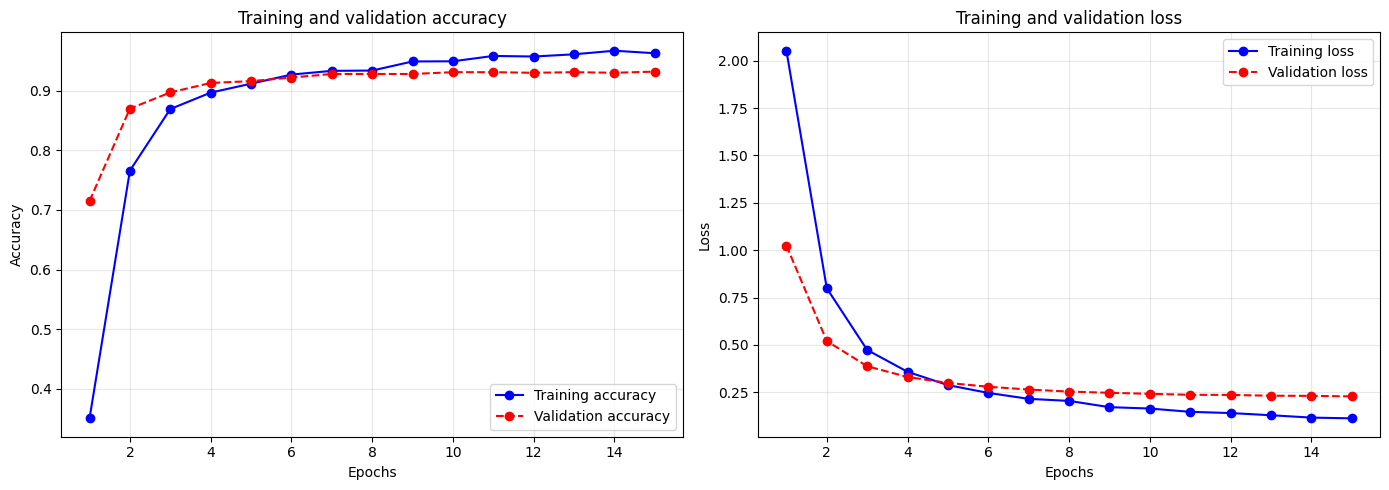

In [19]:

hist_mobile_net, loss_mobile_net, acc_mobile_net, prec_mobile_net, rec_mobile_net, f1_mobile_net = entrenar(
    mobile_net,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets)
)

plot(hist_mobile_net)


#### 4.2 Modelo 2 - EfficientNetB0 con Feature Extraction

In [20]:
def crear_efficient_net(tamano_imagen, num_clases):
    inputs = keras.Input(shape=tamano_imagen, name="input")

    x = layers.Lambda(lambda t: keras.applications.efficientnet.preprocess_input(t * 255.0),
                      name="scale_to_255")(inputs)

    # Base EfficientNetB0
    base = keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=tamano_imagen,
        pooling=None
    )
    base.trainable = False

    # Feature extraction
    x = base(x, training=False)

    # Classifier head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_clases, activation="softmax")(x)

    # Crear modelo
    modelo = models.Model(inputs, outputs, name="efficientnetb0")

    # Compilar
    modelo.compile(
        optimizer=keras.optimizers.Adam(5e-4),
        loss="categorical_crossentropy",
        metrics=[
            'accuracy',
            metrics.Precision(name='precision'),
            metrics.Recall(name='recall'),
            metrics.F1Score(name='f1_score', average='macro')
        ]
    )

    return modelo

efficient_net = crear_efficient_net(tamano_imagen, num_clases)
efficient_net.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scale_to_255 (Lambda)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 3, 3, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.2432 - f1_score: 0.2359 - loss: 2.1555 - precision: 0.8612 - recall: 0.0026 - val_accuracy: 0.6630 - val_f1_score: 0.6612 - val_loss: 1.4486 - val_precision: 0.9367 - val_recall: 0.0740
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6987 - f1_score: 0.6873 - loss: 1.2959 - precision: 0.9687 - recall: 0.1869 - val_accuracy: 0.7980 - val_f1_score: 0.8007 - val_loss: 0.9689 - val_precision: 0.9500 - val_recall: 0.4180
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8181 - f1_score: 0.8125 - loss: 0.8831 - precision: 0.9587 - recall: 0.4795 - val_accuracy: 0.8420 - val_f1_score: 0.8446 - val_loss: 0.7382 - val_precision: 0.9480 - val_recall: 0.6020
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8613 - f1_score: 0.8584 - loss: 0.6695 - precision: 0.9471 - recall: 0.6418 - val_accuracy: 0.8550 - val_f1_score: 0.8579 - val_loss: 0.6149 - val_precision: 0.9441 - val_recall: 0.69

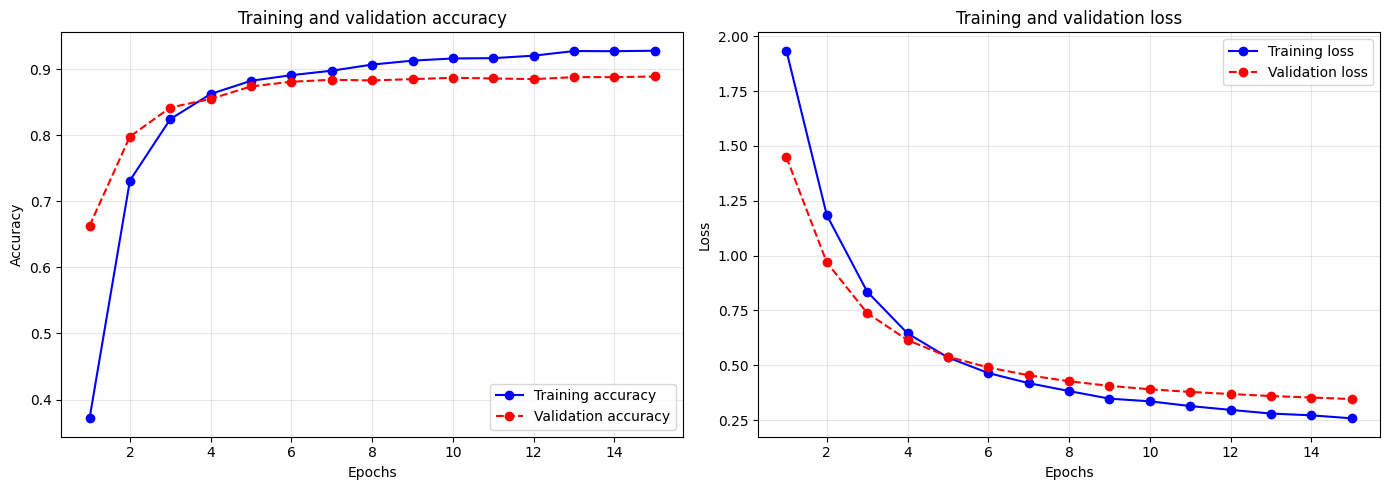

In [21]:
hist_efficientnet, loss_efficientnet, acc_efficientnet, prec_efficientnet, rec_efficientnet, f1_efficientnet = entrenar(
    efficient_net,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets)
)

plot(hist_efficientnet)

#### 4.3 Modelo 3 - Mobilenetv2 con Fine Tunning

In [22]:
def aplicar_fine_tuning(modelo, learning_rate=1e-5):
    """
    Descongela las últimas capas del modelo para fine-tuning

    Args:
        modelo: Modelo ya entrenado con transfer learning
        learning_rate: Learning rate bajo para fine-tuning (default: 1e-5)
    """
    base_model = modelo.layers[2]  # La capa con nombre del modelo base

    # Descongelar el modelo base
    base_model.trainable = True

    # Congelar las primeras 100 capas
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Verificar cuántas capas son entrenables
    print(f"Capas totales en base: {len(base_model.layers)}")
    print(f"Capas entrenables: {sum([1 for layer in base_model.layers if layer.trainable])}")

    # Recompilar con learning rate MUY bajo
    modelo.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss="categorical_crossentropy",
        metrics=[
            'accuracy',
            metrics.Precision(name='precision'),
            metrics.Recall(name='recall'),
            metrics.F1Score(name='f1_score', average='macro')
        ]
    )

    print(f"\nFine-tuning activado con LR={learning_rate}")
    return modelo

FASE 1: Transfer Learning


Model: "mobilenetv2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preproc (Lambda)                │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 543ms/step - accuracy: 0.2417 - f1_score: 0.2428 - loss: 2.3431 - precision: 0.3459 - recall: 0.0891 - val_accuracy: 0.7450 - val_f1_score: 0.7465 - val_loss: 0.9387 - val_precision: 0.8869 - val_recall: 0.5020
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7562 - f1_score: 0.7531 - loss: 0.8418 - precision: 0.8668 - recall: 0.5825 - val_accuracy: 0.8700 - val_f1_score: 0.8734 - val_loss: 0.5034 - val_precision: 0.9288 - val_recall: 0.7830
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8611 - f1_score: 0.8598 - loss: 0.4723 - precision: 0.9232 - recall: 0.7943 - val_accuracy: 0.8970 - val_f1_score: 0.9000 - val_loss: 0.3865 - val_precision: 0.9301 - val_recall: 0.8520
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8960 - f1_score: 0.8956 - loss: 0.3534 - precision: 0.9354 - recall: 0.8521 - val_accuracy: 0.9060 - val_f1_score: 0.9090 - val_loss: 0.3313 - val_precision: 0.9311 - val_recall: 0

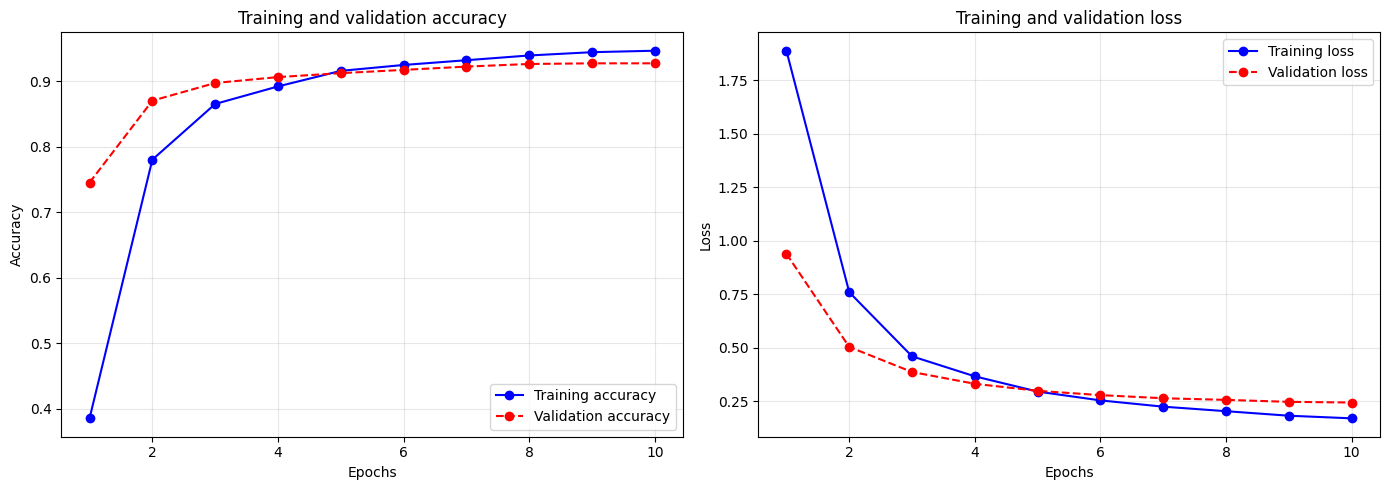



FASE 2: Fine-Tuning
Capas totales en base: 154
Capas entrenables: 54

Fine-tuning activado con LR=3e-05
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 673ms/step - accuracy: 0.8926 - f1_score: 0.8938 - loss: 0.3359 - precision: 0.9249 - recall: 0.8566 - val_accuracy: 0.9330 - val_f1_score: 0.9339 - val_loss: 0.2368 - val_precision: 0.9421 - val_recall: 0.9270
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9614 - f1_score: 0.9613 - loss: 0.1296 - precision: 0.9731 - recall: 0.9440 - val_accuracy: 0.9390 - val_f1_score: 0.9396 - val_loss: 0.2285 - val_precision: 0.9443 - val_recall: 0.9320
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9768 - f1_score: 0.9762 - loss: 0.0890 - precision: 0.9829 - recall: 0.9671 - val_accuracy: 0.9420 - val_f1_score: 0.9424 - val_loss: 0.2205 - val_precision: 0.9454 - val_recall: 0.9350
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9864 - f1_score: 0.9861 - loss: 0.0598 - precision: 0.9901 - recall: 0.982

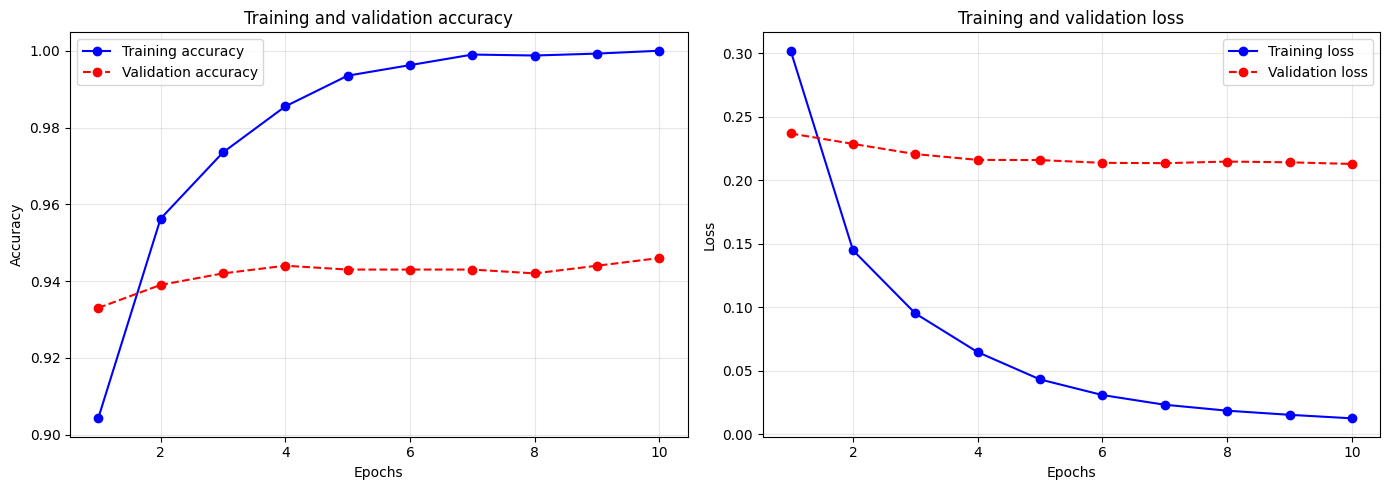

In [23]:
# Primero Transfer Learning (Feature Extraction)
print("FASE 1: Transfer Learning")
mobile_net_ft = crear_mobile_net(tamano_imagen, num_clases)
mobile_net_ft.summary()

# Entrenar SOLO el clasificador (5-10 épocas)
hist_mobile_net_ft, loss_mobile_net_ft, acc_mobile_net_ft, prec_mobile_net_ft, rec_mobile_net_ft, f1_mobile_net_ft = entrenar(
    mobile_net_ft,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets), epochs = 10
)

# Visualizar
plot(hist_mobile_net_ft)


print("\n\nFASE 2: Fine-Tuning")

# Aplicar fine-tuning al modelo ya entrenado
mobile_net_ft_finetuned = aplicar_fine_tuning(mobile_net_ft, learning_rate=3e-5)

# Continuar entrenamiento con capas descongeladas (10-20 épocas)
hist_mobile_net_ft_finetuned, loss_mobile_net_ft_finetuned, acc_mobile_net_ft_finetuned, prec_mobile_net_ft_finetuned, rec_mobile_net_ft_finetuned, f1_mobile_net_ft_finetuned = entrenar(
    mobile_net_ft_finetuned,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets), epochs = 10
)

# Visualizar
plot(hist_mobile_net_ft_finetuned)

#### 4.4 Modelo 4 - EfficientNetB0 con Fine Tunning

FASE 1: Transfer Learning


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scale_to_255 (Lambda)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 3, 3, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 775ms/step - accuracy: 0.1812 - f1_score: 0.1748 - loss: 2.2857 - precision: 0.4170 - recall: 0.0034 - val_accuracy: 0.6430 - val_f1_score: 0.6395 - val_loss: 1.5135 - val_precision: 0.9825 - val_recall: 0.0560
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6483 - f1_score: 0.6407 - loss: 1.3824 - precision: 0.9508 - recall: 0.1290 - val_accuracy: 0.8070 - val_f1_score: 0.8084 - val_loss: 0.9953 - val_precision: 0.9644 - val_recall: 0.3790
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8102 - f1_score: 0.8077 - loss: 0.9151 - precision: 0.9467 - recall: 0.4526 - val_accuracy: 0.8570 - val_f1_score: 0.8590 - val_loss: 0.7450 - val_precision: 0.9587 - val_recall: 0.5810
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8609 - f1_score: 0.8590 - loss: 0.6821 - precision: 0.9549 - recall: 0.6271 - val_accuracy: 0.8770 - val_f1_score: 0.8792 - val_loss: 0.6129 - val_precision: 0.9562 - val_recall: 0

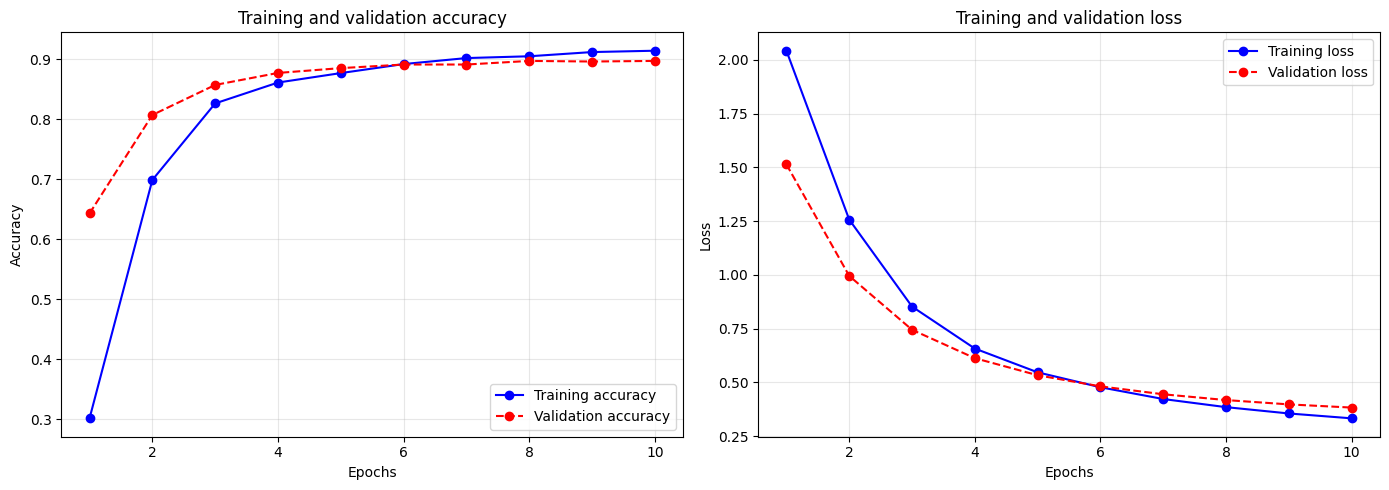



FASE 2: Fine-Tuning
Capas totales en base: 238
Capas entrenables: 138

Fine-tuning activado con LR=3e-05
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.6529 - f1_score: 0.6584 - loss: 1.0787 - precision: 0.8117 - recall: 0.5102 - val_accuracy: 0.8880 - val_f1_score: 0.8894 - val_loss: 0.3747 - val_precision: 0.9305 - val_recall: 0.8570
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.7682 - f1_score: 0.7695 - loss: 0.7390 - precision: 0.8880 - recall: 0.6481 - val_accuracy: 0.8880 - val_f1_score: 0.8898 - val_loss: 0.3809 - val_precision: 0.9248 - val_recall: 0.8490
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.8153 - f1_score: 0.8154 - loss: 0.5791 - precision: 0.9119 - recall: 0.7176 - val_accuracy: 0.8840 - val_f1_score: 0.8861 - val_loss: 0.3893 - val_precision: 0.9134 - val_recall: 0.8440
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.8699 - f1_score: 0.8701 - loss: 0.4602 - precision: 0.9363 - recall: 0.7827

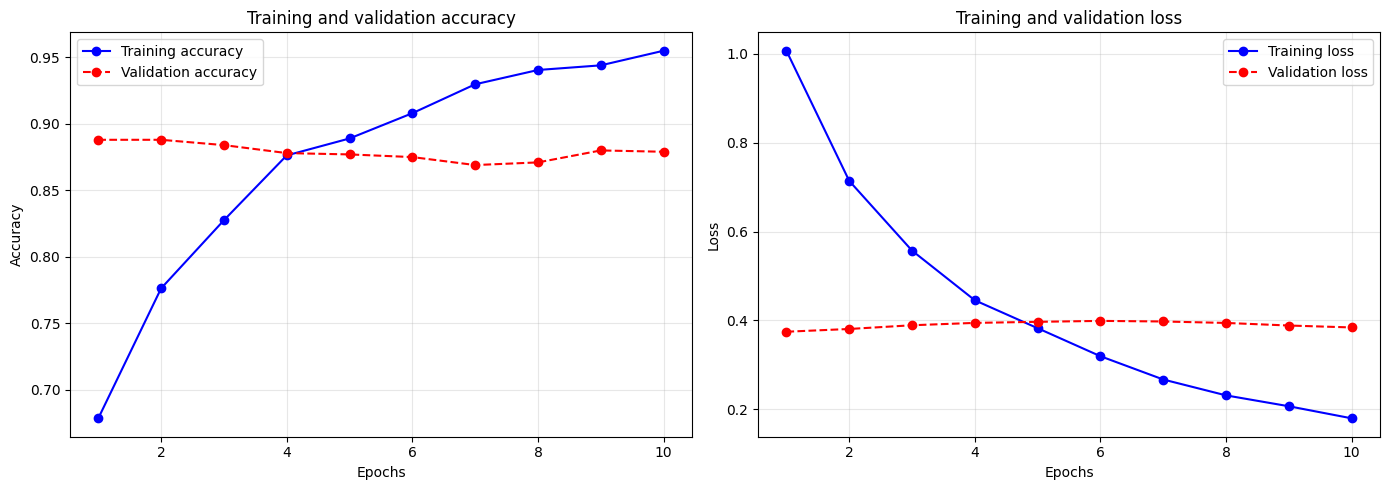

In [24]:
# Primero Transfer Learning (Feature Extraction)
print("FASE 1: Transfer Learning")
efficient_net_ft = crear_efficient_net(tamano_imagen, num_clases)
efficient_net_ft.summary()

# Entrenar SOLO el clasificador (5-10 épocas)
hist_efficient_net_ft, loss_efficient_net_ft, acc_efficient_net_ft, prec_efficient_net_ft, rec_efficient_net_ft, f1_efficient_net_ft = entrenar(
    efficient_net_ft,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets), epochs = 10
)

# Visualizar
plot(hist_efficient_net_ft)


# ============================================
print("\n\nFASE 2: Fine-Tuning")

# Aplicar fine-tuning al modelo ya entrenado
efficient_net_ft_finetuned = aplicar_fine_tuning(efficient_net_ft, learning_rate=3e-5)

# Continuar entrenamiento con capas descongeladas (10-20 épocas)
hist_efficient_net_ft_finetuned, loss_efficient_net_ft_finetuned, acc_efficient_net_ft_finetuned, prec_efficient_net_ft_finetuned, rec_efficient_net_ft_finetuned, f1_efficient_net_ft_finetuned = entrenar(
    efficient_net_ft_finetuned,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets), epochs = 10
)

# Visualizar
plot(hist_efficient_net_ft_finetuned)

In [25]:
# Creamos la tabla con los resultados obtenidos
results = pd.DataFrame({
    "Modelo": ["MobileNetv2 Feature Extraction","EfficientNetB0 Feature Extraction","MobileNetv2 Fine Tuning", "EfficientNetB0 Fine Tuning"],
    "Accuracy": [acc_mobile_net * 100,acc_efficientnet* 100, acc_mobile_net_ft_finetuned*100, acc_efficient_net_ft_finetuned * 100],
    "Precision": [prec_mobile_net,prec_efficientnet,prec_mobile_net_ft_finetuned, rec_efficient_net_ft_finetuned],
    "Recall": [rec_mobile_net,rec_efficientnet,rec_mobile_net_ft_finetuned, rec_efficient_net_ft_finetuned],
    "F1-Score": [f1_mobile_net,f1_efficientnet,f1_mobile_net_ft_finetuned,f1_efficient_net_ft_finetuned],
    "Loss": [loss_mobile_net,loss_efficientnet,loss_mobile_net_ft_finetuned,loss_efficient_net_ft_finetuned]
})

results = results.round({"Accuracy": 3,"Precision": 3,"Recall": 3,"F1-Score": 3})

# Mostramos la tabla ordenada por Accuracy descendente
results.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

,Modelo,Accuracy,Precision,Recall,F1-Score,Loss
0,MobileNetv2 Fine Tuning,94.012,0.947,0.937,0.940,0.202215
1,MobileNetv2 Feature Extraction,93.650,0.947,0.925,0.937,0.206894
2,EfficientNetB0 Feature Extraction,91.150,0.942,0.880,0.911,0.301183
3,EfficientNetB0 Fine Tuning,88.975,0.857,0.857,0.890,0.342774
